In [4]:
%matplotlib inline

from yapss import Problem
import numpy as np
import matplotlib.pyplot as plt

import helpers

In [5]:
### Global settings
PASSIVE_BOT = True  # Set to True to run with zero input and simulate dynamics only
TORQUE_MAX = 8  # N-m; max input magnitude

In [6]:
### Acrobot parameters (taken from Spong 1995)
# Masses (kg)
m1 = 1.
m2 = 1.
# Link lengths (m)
l1 = 1.
l2 = 2.
# Centers of masses (m)
lc1 = 0.5
lc2 = 1.
# Moments of inertia
I1 = 0.083
I2 = 0.33
# Gravity
g = 9.8

In [7]:
### Problem parameters
t0 = 0
tf = 10
R = 10

if PASSIVE_BOT:
    x0 = [-np.pi/2, 0, 0, 0]
else:
    x0 = [0, 0, 0, 0]
    xf = [np.pi, 0, 0, 0]

# Acrobot state: [theta1, theta2, theta1_dot, theta2_dot]
# input: [torque] (at elbow joint only)
problem = Problem(name="acrobot", nx=[4], nu=[1], nq=[1])

In [8]:
### Acrobot dynamics & objective function

def objective(arg):
    arg.objective = arg.phase[0].integral[0]

def continuous(arg):
    theta1, theta2, theta1_dot, theta2_dot = arg.phase[0].state
    u, = arg.phase[0].control  # elbow torque

    # M(q)*q_ddot + C(q, q_dot)*q_dot = tau_g(q) + Bu
    # q = [theta1, theta2]^T

    # M, mass matrix
    M = np.array([[I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*np.cos(theta2), I2 + m2*l1*lc2*np.cos(theta2)],
                  [I2 + m2*l1*lc2*np.cos(theta2), I2]])

    # C, Coriolis terms
    C = np.array([[-2*m2*l1*lc2*np.sin(theta2)*theta2_dot, -m2*l1*lc2*np.sin(theta2)*theta2_dot],
               [m2*l1*lc2*np.sin(theta2)*theta1_dot, 0]])

    # tau_g, gravity terms
    tau_g = np.array([-m1*g*lc1*np.sin(theta1) - m2*g*(l1*np.sin(theta1) + lc2*np.sin(theta1 + theta2)),
                   -m2*g*lc2*np.sin(theta1 + theta2)])

    # Combine to make the big matrix, call it M_block
    # NOTE I'm doing it this way because numpy tries to invert block matrices as their individual blocks
    # So even when the overall matrix is invertible, it says it's singular if C is singular
    M_block = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [C[0,0], C[0,1], M[0,0], M[0,1]],
                     [C[1,0], C[1,1], M[1,0], M[1,1]]])
    
    M_block_inv = helpers.inv_4x4(M_block)

    arg.phase[0].dynamics[:] = M_block_inv @ np.array([theta1_dot, theta2_dot, tau_g[0], tau_g[1] + u]).reshape(4, 1)

    if PASSIVE_BOT:
        arg.phase[0].integrand[0] = 0.
    else:
        arg.phase[0].integrand[0] = R * u**2 # Cost only on input "effort"

functions = problem.functions
functions.objective = objective
functions.continuous = continuous

In [9]:
### Set bounds
bounds = problem.bounds.phase[0]

# Initial conditions
bounds.initial_time.lower = bounds.initial_time.upper = t0
bounds.initial_state.lower = bounds.initial_state.upper = x0

# Final time
bounds.final_time.lower = bounds.final_time.upper = tf

# Control bounds (torque, N*m)
if PASSIVE_BOT:
    bounds.control.lower[:] = bounds.control.upper[:] = (0,)
else:
    bounds.control.lower[:] = (-TORQUE_MAX,)
    bounds.control.upper[:] = (TORQUE_MAX,)

In [11]:
### Initial guess
phase = problem.guess.phase[0]
phase.time = (t0, tf)
phase.state = ((x0[0], 0), (0, 0), (0, 0), (0, 0))
phase.control = ((0, 0),)

In [12]:
### Mesh and solver settings
m, n = 10, 10
problem.mesh.phase[0].collocation_points = m * (n,)
problem.mesh.phase[0].mesh_fraction = m * (1.0 / m,)

problem.derivatives.order = "second"
problem.derivatives.method = "auto"
problem.spectral_method = "lgl"
problem.ipopt_options.tol = 1e-10

In [13]:
### Solve
output = problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5172
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      720

Total number of variables............................:      401
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      401
Total number of inequality c

In [14]:
# extract information from solution
time = output.solution.phase[0].time
time_u = output.solution.phase[0].time_u
q1, q2, q1_dot, q2_dot = output.solution.phase[0].state
(torque,) = output.solution.phase[0].control
phase = output.solution.phase[0]

# initial and final time
t0 = output.solution.phase[0].t0
tf = output.solution.phase[0].tf

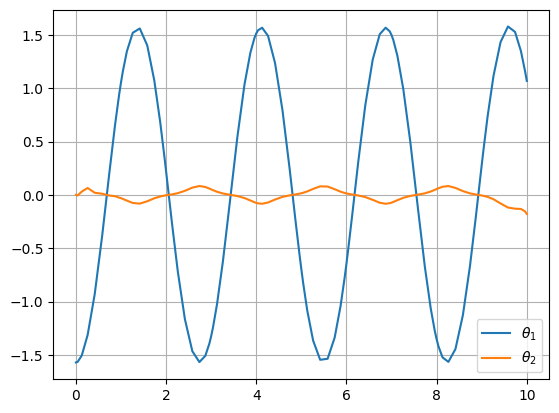

In [15]:
# Plot thetas
plt.figure()
plt.plot(time, q1, label="$\\theta_1$")
plt.plot(time, q2, label="$\\theta_2$")
plt.grid()
plt.legend()

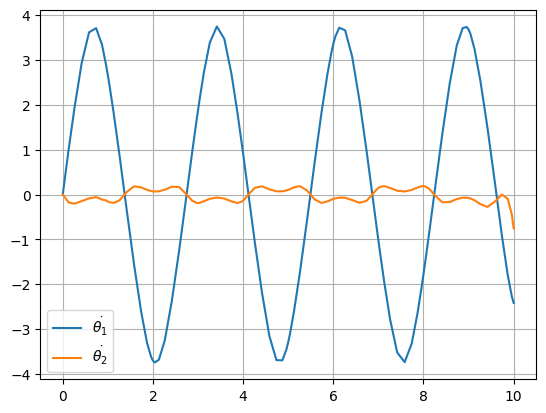

In [16]:
# Plot theta_dots
plt.figure()
plt.plot(time, q1_dot, label="$\\dot{\\theta_1}$")
plt.plot(time, q2_dot, label="$\\dot{\\theta_2}$")
plt.grid()
plt.legend()

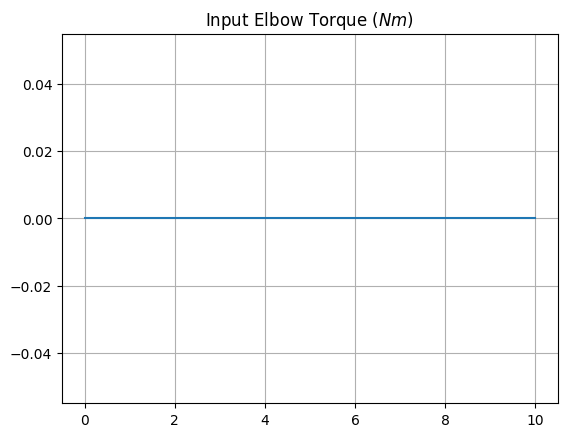

In [17]:
# Plot torque
plt.figure()
plt.plot(time_u, torque, label="$\\tau$")
plt.title("Input Elbow Torque ($Nm$)")
plt.grid()

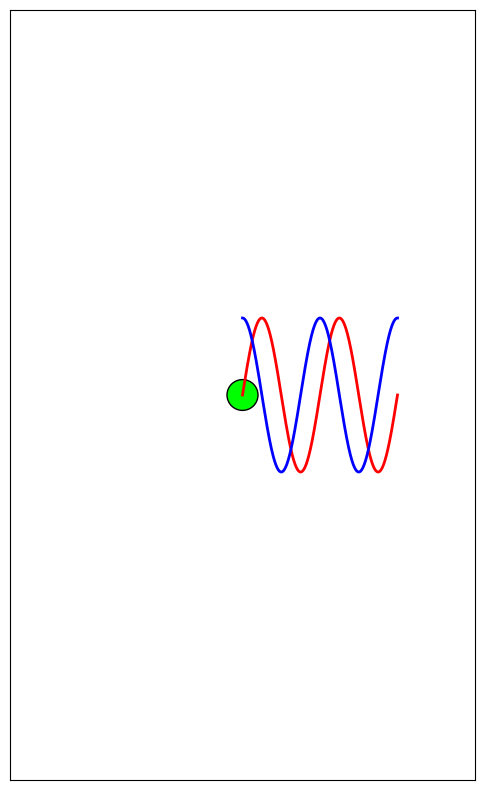

In [18]:
### Animate solution
# Adapted from: https://jckantor.github.io/CBE30338/A.03-Animation-in-Jupyter-Notebooks.html

from matplotlib import patches, animation, rc
rc("animation", html="html5")
from functools import partial

fig = plt.figure(figsize=(6,10))
ax1 = plt.subplot(111)
ax1.set_xlim((-3, 3))
ax1.set_ylim((-5, 5))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

# Shoulder joint doesn't move
ax1.add_patch(patches.Circle((0, 0), 0.2, facecolor='lime', edgecolor='black'))

## Create objects that will change in the animation
# Initially empty, but will be given new values for each frame in the animation
link1, = ax1.plot([], [], 'r', lw=2)  # ax.plot returns a list of 2D line objects
link2, = ax1.plot([], [], 'b', lw=2)

## Animation function
# Must return parts of the frame that have changed in order to use blit
def drawframe(n_frame, q1, q2):
    x = np.linspace(0, 2, 1000)
    y1 = np.sin(2 * np.pi * (x - 0.01 * n_frame))
    y2 = np.cos(2 * np.pi * (x - 0.01 * n_frame))
    link1.set_data(x, y1)
    link2.set_data(x, y2)
    return (link1, link2)

## Create the animation object
# interval is in ms
# blit=True redraws only the parts that have changed
anim = animation.FuncAnimation(fig, partial(drawframe, q1=q1, q2=q2), frames=len(q1), interval=20, blit=True)